In [20]:
import os
import math
import json
import random
import multiprocessing
from typing import Dict, Tuple, List, Optional

# Import utility functions
from cjm_pandas_utils.core import markdown_to_pandas
from cjm_pytorch_utils.core import set_seed, get_torch_device

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Set options for Pandas DataFrame display
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

# Import PIL for image manipulation
from PIL import Image, ImageFile, UnidentifiedImageError

# Import timm library
import timm
from timm.models import resnet

# Import PyTorch dependencies
import torch
import torchvision.transforms.functional as TF
from torch import nn, Tensor
from torchvision import transforms
from torch.amp import autocast
from torch.cuda.amp import GradScaler
from torch.utils.data import Dataset, DataLoader
from torcheval.metrics import MulticlassAccuracy
from torchtnt.utils import get_module_summary
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split

In [21]:
# Setting Up the Project

In [22]:
# Set the seed for generating random numbers in PyTorch, NumPy, and Python's random module.
seed = 1234
set_seed(seed)

In [23]:
# Set the Device and Data Type
device = get_torch_device()
dtype = torch.float32
print(device, dtype)

ImageFile.LOAD_TRUNCATED_IMAGES = True

cuda torch.float32


In [24]:
# Loading and Exploring the Dataset

In [25]:
# Create labels

In [26]:
data_path = 'C:\\Users\\Administrator\\Downloads\\bag_image'

def list_nested_files(directory):
    files = []
    for root, dirs, filenames in os.walk(directory):
        for filename in filenames:
            file_path = os.path.join(root, filename)
            files.append(file_path)
    return files


image_files = []
class_labels = []

all_files = list_nested_files(data_path)
for file in all_files:
    parts = file.split('\\')
    image_files.append('\\'.join(parts))
    class_labels.append('|'.join(parts[5:-1]))
    
print(class_labels[:10])

['Balenciaga|city|handbag', 'Balenciaga|city|handbag', 'Balenciaga|city|handbag', 'Balenciaga|city|handbag', 'Balenciaga|city|handbag', 'Balenciaga|city|handbag', 'Balenciaga|city|handbag', 'Balenciaga|city|handbag', 'Balenciaga|city|handbag', 'Balenciaga|city|handbag']


In [27]:
# count by labels
cc = pd.DataFrame(class_labels, columns=['label'])
# Group by the labels and count the occurrences
grouped = cc.groupby('label').size().sort_values(ascending=False)
# Convert the Series to a DataFrame and reset the index
class_count = grouped.reset_index(name='count')
class_count.columns = ['label', 'count']
class_count.set_index('label', inplace=True)
class_count.index.name = None
class_count.head()
# class_count.to_csv('counts.csv')

,count
Bottega Veneta|veneta|handbag,715
Balenciaga|city|handbag,317
Fendi|baguette|handbag,311
Bvlgari|serpenti|handbag,281
Louis Vuitton|neverfull|tote|mm,156


In [28]:
# map label to intdex
class_names = sorted(list(set(class_labels)))
class_map = dict(zip(class_names, range(len(class_names))))

classification_map = pd.DataFrame.from_dict(class_map, orient='index')
classification_map.columns = ['label_int']
classification_map.head()
# classification_map.to_csv('labels.csv')

,label_int
Balenciaga|city|handbag,0
Balenciaga|classic|handbag,1
Balenciaga|day|handbag,2
Balenciaga|hourglass|crossbody,3
Balenciaga|hourglass|top handle|small,4


In [29]:
# Visualize the class distribution

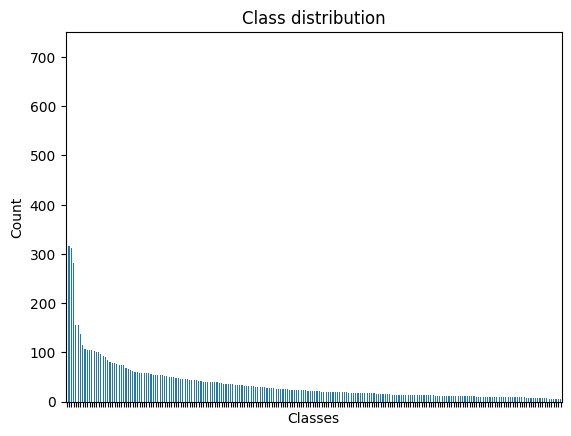

In [30]:
# Plot the distribution
class_count.plot(kind='bar')
plt.title('Class distribution')
plt.ylabel('Count')
plt.xlabel('Classes')
# plt.xticks(range(len(class_count.index)), class_count.index)  # Set the x-axis tick labels
# plt.xticks(rotation=75)  # Rotate x-axis labels
plt.xticks(visible=False)  # Set x-axis tick labels invisible
plt.gca().legend().set_visible(False)
plt.show()

In [31]:
# Visualizing Sample Images

In [32]:
# Get paths for the first sample in the dataset for each class

def get_sample_paths():
    sample_paths = []
    for class_name in class_names:
        # Replace '|' with os.sep to construct the path
        class_path = os.path.join(data_path, *class_name.split('|'))
        if os.path.isdir(class_path):
            files = os.listdir(class_path)
            # Filter out directories and get only files
            files = [f for f in files if os.path.isfile(os.path.join(class_path, f))]
            
            # Check if there are any files in the directory
            if files:
                # Get the first file
                first_image = files[0]
                # Construct the full path to the first image
                first_image_path = os.path.join(class_path, first_image)
                # Store the path in the list
                sample_paths.append((first_image_path, class_name))  # Store path and class name as a tuple
            else:
                print(f"No files found in directory {class_path}")
        else:
            print(f"Directory does not exist: {class_path}") 
    return sample_paths

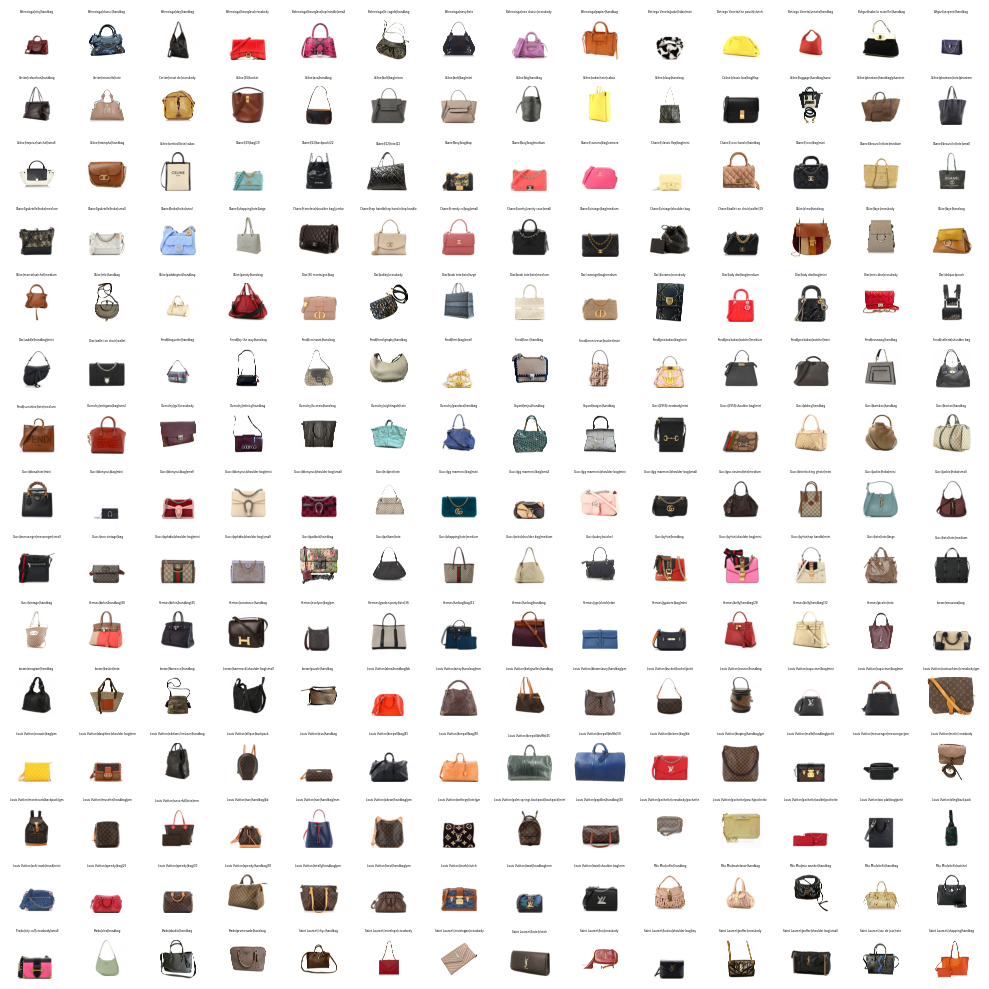

In [17]:
# Get paths for the first sample in the dataset for each class
sample_paths = get_sample_paths()
sample_paths.sort(key=lambda x: x[0])  # Sort by file path

# Calculate the number of rows and columns for the grid
grid_size = math.floor(math.sqrt(len(sample_paths)))
n_rows = grid_size + (1 if grid_size**2 < len(sample_paths) else 0)
n_cols = grid_size

# Create a list to store the first image found for each class
images = [Image.open(path) for path, _ in sample_paths]
labels = [label for _, label in sample_paths]

# Create a figure for the grid
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 10))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Plot each image
for ax, img, label in zip(axs, images, labels):
    ax.imshow(img)
    ax.set_title(label, fontsize=2) 
    ax.axis('off')

# Hide any remaining empty subplots
for ax in axs[len(images):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [18]:
# Selecting a Model

In [37]:
# Exploring Available Models

pd.DataFrame(timm.list_models('resnet152d*', pretrained=True))

,0
0,resnet152d.gluon_in1k
1,resnet152d.ra2_in1k


In [38]:
resnet_model = 'resnet152d'
model_cfg = resnet.default_cfgs[resnet_model].default.to_dict()

pd.DataFrame.from_dict(model_cfg, orient='index')

,0
url,https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet152d_ra2-5cac0439.pth
hf_hub_id,timm/
custom_load,False
input_size,"(3, 256, 256)"
test_input_size,"(3, 320, 320)"
fixed_input_size,False
interpolation,bicubic
crop_pct,0.95
test_crop_pct,1.0
crop_mode,center


In [39]:
# Retrieve normalization statistics (mean and std) specific to the pretrained model
mean, std = model_cfg['mean'], model_cfg['std']
norm_stats = (mean, std)

# Print the mean and standard deviation
print(norm_stats)

((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))


In [40]:
# Create a pretrained ResNet model with the number of output classes equal to the number of class names
# 'timm.create_model' function automatically downloads and initializes the pretrained weights
resnet152 = timm.create_model(resnet_model, pretrained=True, num_classes=len(class_names))

# Set the device and data type for the model
resnet152 = resnet152.to(device=device, dtype=dtype)

# Add attributes to store the device and model name for later reference
resnet152.device = device
resnet152.name = resnet_model

In [41]:
# Select the model
model = resnet152

In [42]:
# Summarize the Model

# Define the input to the model
test_inp = torch.randn(1, 3, 256, 256).to(device)

# Get a summary of the model as a Pandas DataFrame
summary_df = markdown_to_pandas(f"{get_module_summary(model, [test_inp])}")

# Filter the summary to only contain Conv2d layers and the model
summary_df = summary_df[(summary_df.index == 0) | (summary_df['Type'] == 'Conv2d')]

# Remove the column "Contains Uninitialized Parameters?"
summary_df.drop('Contains Uninitialized Parameters?', axis=1)

,Type,# Parameters,# Trainable Parameters,Size (bytes),Forward FLOPs,Backward FLOPs,In size,Out size
0,ResNet,58.6 M,58.6 M,235 M,15.3 G,30.7 G,"[1, 3, 256, 256]","[1, 218]"
2,Conv2d,864,864,3.5 K,14.2 M,14.2 M,"[1, 3, 256, 256]","[1, 32, 128, 128]"
5,Conv2d,9.2 K,9.2 K,36.9 K,150 M,301 M,"[1, 32, 128, 128]","[1, 32, 128, 128]"
8,Conv2d,18.4 K,18.4 K,73.7 K,301 M,603 M,"[1, 32, 128, 128]","[1, 64, 128, 128]"
14,Conv2d,4.1 K,4.1 K,16.4 K,16.8 M,33.6 M,"[1, 64, 64, 64]","[1, 64, 64, 64]"
17,Conv2d,36.9 K,36.9 K,147 K,150 M,301 M,"[1, 64, 64, 64]","[1, 64, 64, 64]"
22,Conv2d,16.4 K,16.4 K,65.5 K,67.1 M,134 M,"[1, 64, 64, 64]","[1, 256, 64, 64]"
27,Conv2d,16.4 K,16.4 K,65.5 K,67.1 M,134 M,"[1, 64, 64, 64]","[1, 256, 64, 64]"
30,Conv2d,16.4 K,16.4 K,65.5 K,67.1 M,134 M,"[1, 256, 64, 64]","[1, 64, 64, 64]"
33,Conv2d,36.9 K,36.9 K,147 K,150 M,301 M,"[1, 64, 64, 64]","[1, 64, 64, 64]"


In [25]:
# Preparing the Data

Image Label: Bvlgari|serpenti|handbag


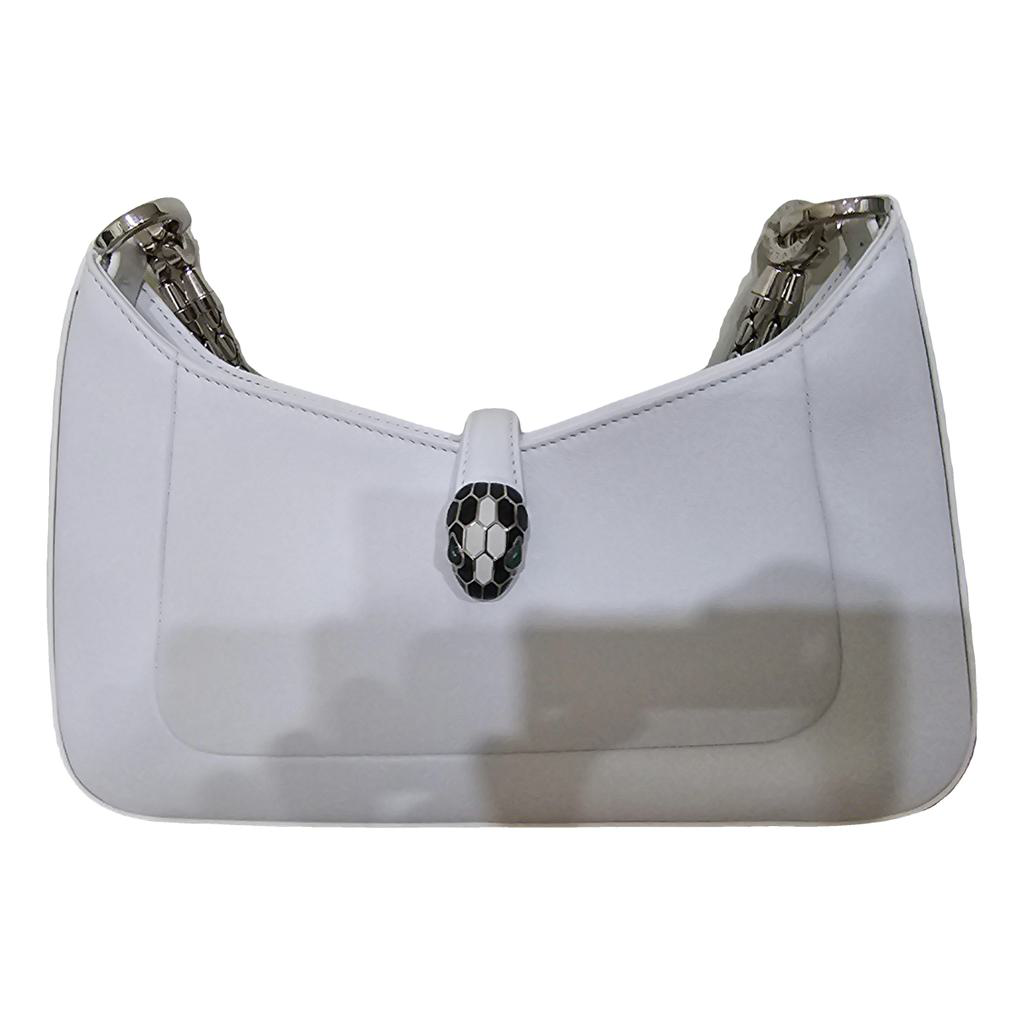

In [45]:
# Select a random item from the dataset
img_path = random.choice(image_files)

label = '|'.join(img_path.split('\\')[5:-1])
sample_img = Image.open(img_path)
    
# Display the image
print(f"Image Label: {label}")
display(sample_img)

In [32]:
# Data Augmentation

In [46]:
# This class extends the TrivialAugmentWide class provided by PyTorch's transforms module.
# TrivialAugmentWide is an augmentation policy randomly applies a single augmentation to each image.

class CustomTrivialAugmentWide(transforms.TrivialAugmentWide):
    # The _augmentation_space method defines a custom augmentation space for the augmentation policy.
    # This method returns a dictionary where each key is the name of an augmentation operation and 
    # the corresponding value is a tuple of a tensor and a boolean value.
    # The tensor defines the magnitude of the operation, and the boolean defines  
    # whether to perform the operation in both the positive and negative directions (True)
    # or only in the positive direction (False).
    def _augmentation_space(self, num_bins: int) -> Dict[str, Tuple[Tensor, bool]]:
        
        # Define custom augmentation space
        custom_augmentation_space = {
            # Identity operation doesn't change the image
            "Identity": (torch.tensor(0.0), False),
            
            # Distort the image along the x or y axis, respectively.
            "ShearX": (torch.linspace(0.0, 0.25, num_bins), True),
            "ShearY": (torch.linspace(0.0, 0.25, num_bins), True),

            # Move the image along the x or y axis, respectively.
            "TranslateX": (torch.linspace(0.0, 32.0, num_bins), True),
            "TranslateY": (torch.linspace(0.0, 32.0, num_bins), True),

            # Rotate operation: rotates the image.
            "Rotate": (torch.linspace(0.0, 45.0, num_bins), True),

            # Adjust brightness, color, contrast,and sharpness respectively.
            "Brightness": (torch.linspace(0.0, 0.75, num_bins), True),
            "Color": (torch.linspace(0.0, 0.99, num_bins), True),
            "Contrast": (torch.linspace(0.0, 0.99, num_bins), True),
            "Sharpness": (torch.linspace(0.0, 0.99, num_bins), True),

            # Reduce the number of bits used to express the color in each channel of the image.
            "Posterize": (8 - (torch.arange(num_bins) / ((num_bins - 1) / 6)).round().int(), False),

            # Invert all pixel values above a threshold.
            "Solarize": (torch.linspace(255.0, 0.0, num_bins), False),

            # Maximize the image contrast by setting the darkest color to black and the lightest to white.
            "AutoContrast": (torch.tensor(0.0), False),

            # Equalize the image histogram to improve its contrast.
            "Equalize": (torch.tensor(0.0), False),
        }
        
        # The function returns the dictionary of operations.
        return custom_augmentation_space

In [47]:
# Create a CustomTrivialAugmentWide the specified augmentation space
trivial_aug = CustomTrivialAugmentWide()

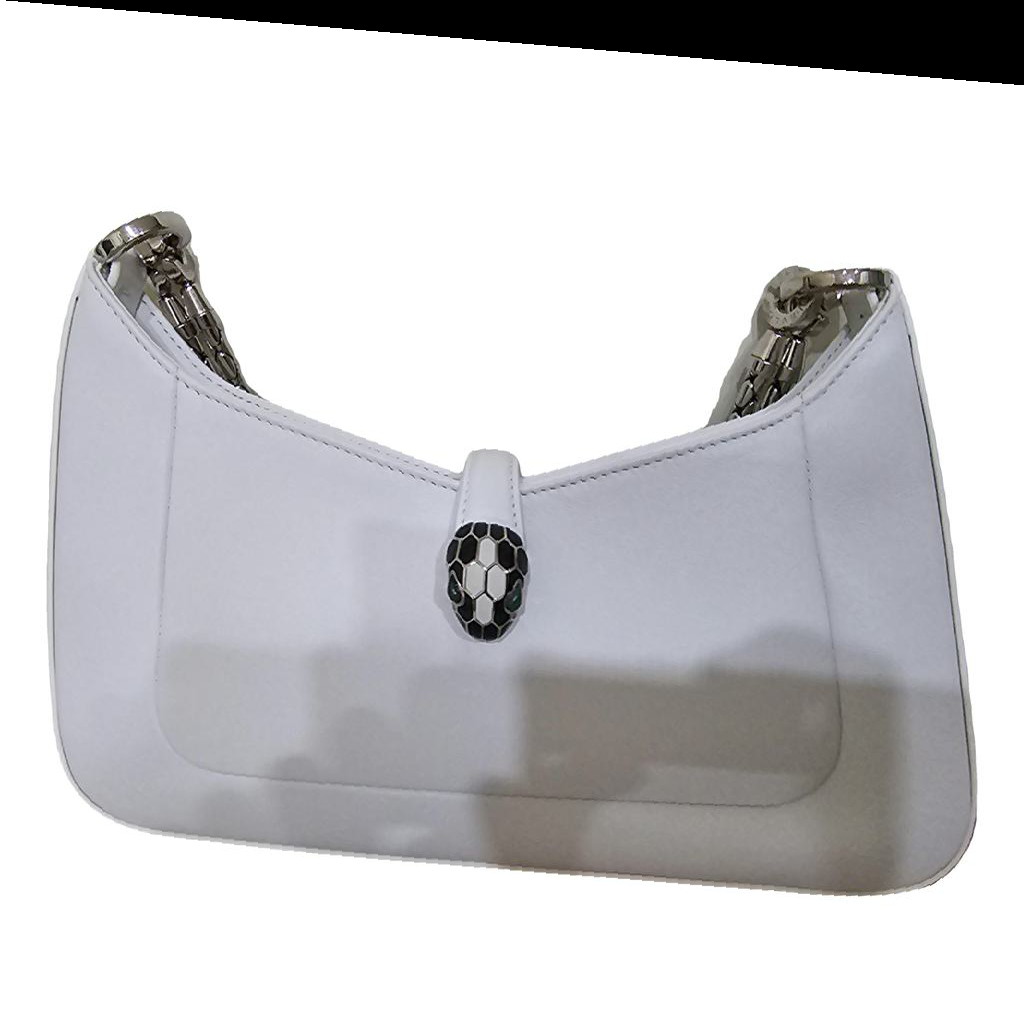

In [50]:
# Apply the TrivialAugmentWide to the tensor (sample test)
trivial_aug(sample_img)

In [51]:
# Image Resizing and Padding

In [52]:
class ResizePad(nn.Module):
    def __init__(self, max_sz=256, padding_mode='edge'):
        """
        A PyTorch module that resizes an image tensor and adds padding to make it a square tensor.

        Args:
        max_sz (int, optional): The size of the square tensor.
        padding_mode (str, optional): The padding mode used when adding padding to the tensor.
        """
        super().__init__()
        self.max_sz = max_sz
        self.padding_mode = padding_mode
        
    def forward(self, x):
        # Get the width and height of the image tensor
        w, h = TF.get_image_size(x)
        
        # Resize the image tensor so that its minimum dimension is equal to `max_sz`
        size = int(min(w, h) / (max(w, h) / self.max_sz))
        x = TF.resize(x, size=size, antialias=True)
        
        # Add padding to make the image tensor a square
        w, h = TF.get_image_size(x)
        offset = (self.max_sz - min(w, h)) // 2
        padding = [0, offset] if h < w else [offset, 0]
        x = TF.pad(x, padding=padding, padding_mode=self.padding_mode)
        x = TF.resize(x, size=[self.max_sz] * 2, antialias=True)
        return x

In [53]:
# Set training image size
train_sz = (320,320)

# Compose transformer to resize and pad input images
train_tfms = transforms.Compose([
    transforms.ToPILImage(),
    ResizePad(max_sz=max(train_sz)),
    trivial_aug, # TrivialAugmentWide
    transforms.ToTensor(),
    transforms.Normalize(*norm_stats), # ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

valid_tfms = transforms.Compose([
    transforms.ToPILImage(),
    ResizePad(max_sz=max(train_sz)),
    transforms.ToTensor(),
    transforms.Normalize(*norm_stats),
])

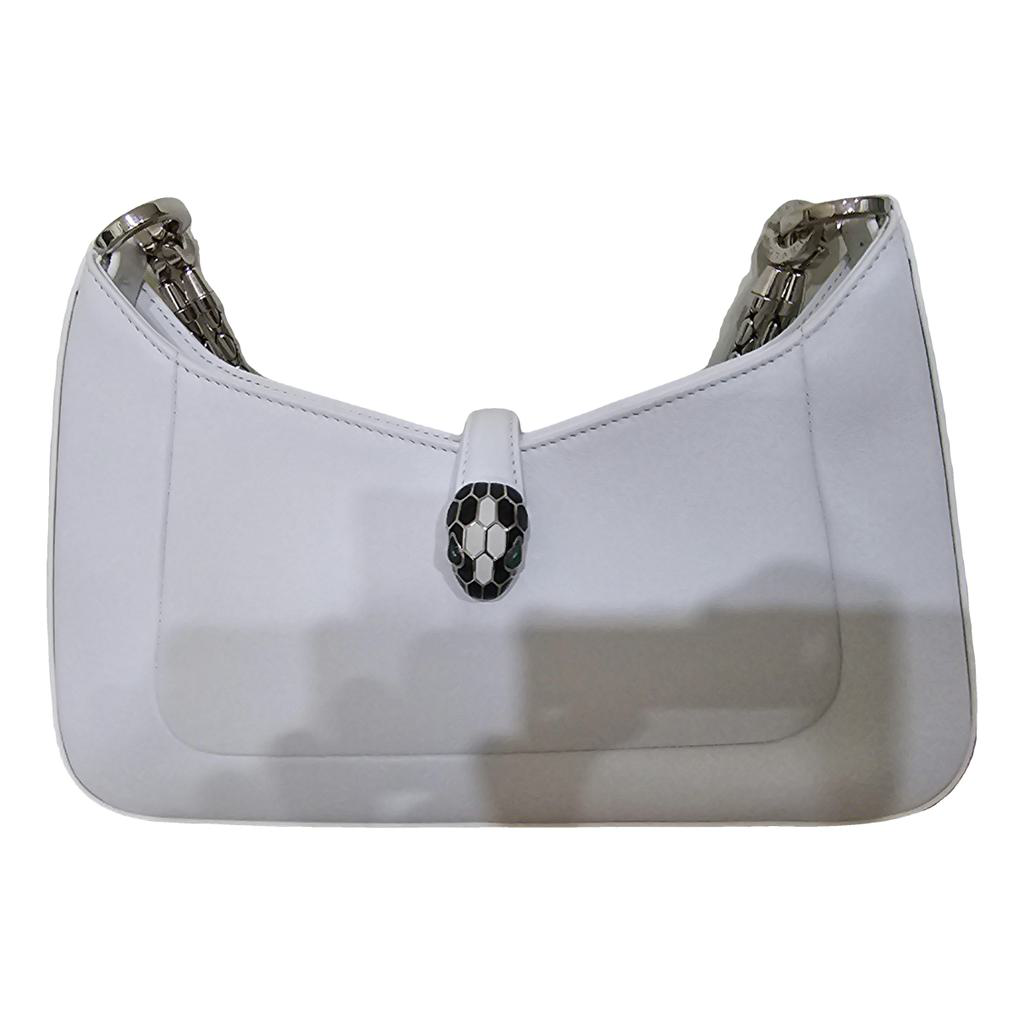

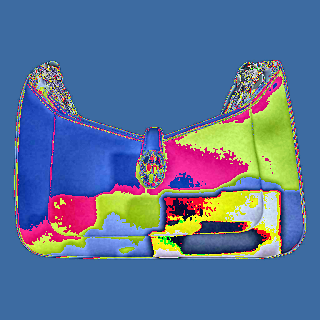

Source Image:,"(1024, 1024)"
Resized Padded Image:,"(320, 320)"


In [54]:
# Resize, pad and apply TrivialAugmentWide to the tensor (sample test)
sample_img_rgb = sample_img.convert('RGB')
display(sample_img_rgb)
sample_img_tensor = np.array(sample_img_rgb)
trans_img_tensor = train_tfms(sample_img_tensor)

trans_img = transforms.ToPILImage()(trans_img_tensor)
display(trans_img)

pd.Series({
    "Source Image:": sample_img.size,
    "Resized Padded Image:": trans_img.size,
}).to_frame().style.hide(axis='columns')

In [40]:
# Split Training Data and Validation Data

In [60]:
class CustomImageDataset(Dataset):
    def __init__(self, image_files, class_map, transform=None, target_transform=None):
        self.img_labels = image_files
        self.class_map = class_map
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, index):
        img_path = self.img_labels[index]
        try:
            image = np.array(Image.open(img_path).convert('RGB'))

            label = '|'.join(img_path.split('\\')[5:-1])
            label_int = self.class_map[label]
            if self.transform:
                image = self.transform(image)
            # if self.target_transform:
            #     label = self.target_transform(label)
        except UnidentifiedImageError:
            print(f'Failed to read image: {img_path}')
            return None

        return image, label_int


def train_val_dataset(image_files, class_labels, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(image_files))), test_size=val_split, stratify=class_labels)
    train_images = [image_files[i] for i in train_idx]
    val_images = [image_files[i] for i in val_idx]
    return train_images, val_images


def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)


def generate_dataset(norm_stats, image_files, class_labels, class_map):
    train_sz = (320, 320)
    trivial_aug = CustomTrivialAugmentWide()
    train_tfms = transforms.Compose([
        transforms.ToPILImage(),
        ResizePad(max_sz=max(train_sz)),
        trivial_aug,
        transforms.ToTensor(),
        transforms.Normalize(*norm_stats),
    ])

    valid_tfms = transforms.Compose([
        transforms.ToPILImage(),
        ResizePad(max_sz=max(train_sz)),
        transforms.ToTensor(),
        transforms.Normalize(*norm_stats),
    ])

    train_split, val_split = train_val_dataset(image_files, class_labels, val_split=0.2)
    
    # Instantiate the datasets using the defined transformations
    train_dataset = CustomImageDataset(train_split, class_map=class_map, transform=train_tfms)
    valid_dataset = CustomImageDataset(val_split, class_map=class_map, transform=valid_tfms)
    
    # Print the number of samples in the training and validation datasets
    print(f'Training dataset size: {len(train_dataset)}')
    print(f'Validation dataset size: {len(valid_dataset)}')
    print(f'Number of image: {len(image_files)}')
    
    # Set the number of worker processes for loading data. This should be the number of CPUs available.
    num_workers = multiprocessing.cpu_count()
    
    # Define parameters for DataLoader
    data_loader_params = {
        'batch_size': 32,  # Batch size for data loading
        'num_workers': num_workers,  # Number of subprocesses to use for data loading
        'persistent_workers': True,  # If True, the data loader will not shutdown the worker processes after a dataset has been consumed once. This allows to maintain the worker dataset instances alive.
        'pin_memory': True,  # If True, the data loader will copy Tensors into CUDA pinned memory before returning them. Useful when using GPU.
        'pin_memory_device': device,  # Specifies the device where the data should be loaded. Commonly set to use the GPU.
    }
    
    # Create DataLoader for training data. Data is shuffled for every epoch.
    train_dataloader = DataLoader(train_dataset, **data_loader_params, shuffle=True)
    
    # Create DataLoader for validation data. Shuffling is not necessary for validation data.
    valid_dataloader = DataLoader(valid_dataset, **data_loader_params)
    
    # Print the number of batches in the training and validation DataLoaders
    print(f'Number of batches in train DataLoader: {len(train_dataloader)}')
    print(f'Number of batches in validation DataLoader: {len(valid_dataloader)}')
    
    return train_dataloader, valid_dataloader


In [61]:
train_dataloader, valid_dataloader = generate_dataset(norm_stats, image_files, class_labels, class_map)

Training dataset size: 6791
Validation dataset size: 1698
Number of image: 8489
Number of batches in train DataLoader: 213
Number of batches in validation DataLoader: 54


In [43]:
# Model Training

In [44]:
# Function to run a single training/validation epoch
def run_epoch(model, dataloader, optimizer, metric, lr_scheduler, device, scaler, epoch, is_training):
    # Set model to training mode if 'is_training' is True, else set to evaluation mode
    model.train() if is_training else model.eval()

    # Reset the performance metric
    metric.reset()
    # Initialize the average loss for the current epoch
    epoch_loss = 0
    # Initialize progress bar with total number of batches in the dataloader
    progress_bar = tqdm(total=len(dataloader), desc="Train" if is_training else "Eval")

    # Iterate over data batches
    for batch_id, (inputs, targets) in enumerate(dataloader):
        # Move inputs and targets to the specified device (e.g., GPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Enables gradient calculation if 'is_training' is True
        with torch.set_grad_enabled(is_training):
            # Automatic Mixed Precision (AMP) context manager for improved performance
            with autocast(device):
                outputs = model(inputs)  # Forward pass
                loss = torch.nn.functional.cross_entropy(outputs, targets)  # Compute loss

        # Update the performance metric
        metric.update(outputs.detach().cpu(), targets.detach().cpu())

        # If in training mode
        if is_training:
            if scaler is not None:  # If using AMP
                # Scale the loss and backward propagation
                scaler.scale(loss).backward()
                scaler.step(optimizer)  # Make an optimizer step
                scaler.update()  # Update the scaler
            else:
                loss.backward()  # Backward propagation
                optimizer.step()  # Make an optimizer step

            optimizer.zero_grad()  # Clear the gradients
            lr_scheduler.step()  # Update learning rate

        loss_item = loss.item()
        epoch_loss += loss_item

        # Update progress bar
        progress_bar.set_postfix(accuracy=metric.compute().item(),
                                 loss=loss_item,
                                 avg_loss=epoch_loss / (batch_id + 1),
                                 lr=lr_scheduler.get_last_lr()[0] if is_training else "")
        progress_bar.update()

        # If loss is NaN or infinity, stop training
        if math.isnan(loss_item) or math.isinf(loss_item):
            print(f"Loss is NaN or infinite at epoch {epoch}, batch {batch_id}. Stopping training.")

    progress_bar.close()
    return epoch_loss / (batch_id + 1)

In [45]:
# Main training loop
def train_loop(model,
               train_dataloader,
               valid_dataloader,
               optimizer,
               metric,
               lr_scheduler,
               device,
               epochs,
               use_amp,
               checkpoint_path,
               model_path):
    # Initialize GradScaler for Automatic Mixed Precision (AMP) if 'use_amp' is True
    scaler = GradScaler() if use_amp else None
    best_loss = float('inf')

    train_loss_list = []
    valid_loss_list = []

    # Iterate over each epoch
    for epoch in tqdm(range(epochs), desc="Epochs"):
        print(f'Running Epoch - {epoch + 1}...')
        # Run training epoch and compute training loss
        train_loss = run_epoch(model,
                               train_dataloader,
                               optimizer,
                               metric,
                               lr_scheduler,
                               device,
                               scaler,
                               epoch,
                               is_training=True)
        train_loss_list.append(train_loss)

        with torch.no_grad():
            # Run validation epoch and compute validation loss
            valid_loss = run_epoch(model,
                                   valid_dataloader,
                                   None,
                                   metric,
                                   None,
                                   device,
                                   scaler,
                                   epoch,
                                   is_training=False)
            valid_loss_list.append(valid_loss)

        # If current validation loss is lower than the best one so far, save model and update best loss
        if valid_loss < best_loss:
            best_loss = valid_loss
            metric_value = metric.compute().item()
            torch.save(model.state_dict(), checkpoint_path)

            training_metadata = {
                'epoch': epoch,
                'train_loss': train_loss,
                'valid_loss': valid_loss,
                'accuracy': metric_value,
                'learning_rate': lr_scheduler.get_last_lr()[0],
                'model_architecture': model.name
            }

            print(training_metadata)

            # Save best_loss and metric_value in a JSON file
            with open('classification_training_metadata.json', 'w') as f:
                json.dump(training_metadata, f)

        # If loss is NaN or infinity, stop training
        if any(math.isnan(loss) or math.isinf(loss) for loss in [train_loss, valid_loss]):
            print(f"Loss is NaN or infinite at epoch {epoch}. Stopping training.")
            break

    # save entire model
    torch.save(model, model_path)
    # If using AMP, clean up the unused memory in GPU
    if use_amp:
        torch.cuda.empty_cache()

    return train_loss_list, valid_loss_list

In [ ]:
# Create a directory to store the checkpoints if it does not already exist
checkpoint_dir = f"model/{resnet_model}/"
# The model checkpoint path
checkpoint_path = checkpoint_dir + "handbag_classfication_weights.pth"
model_path = checkpoint_dir + "handbag_classfication.pt"

# Hyperparameters
# Learning rate for the model
lr = 1e-4

# Number of training epochs
epochs = 10

# AdamW optimizer; includes weight decay for regularization
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-5)

# Learning rate scheduler; adjusts the learning rate during training
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                   max_lr=lr, 
                                                   total_steps=epochs*len(train_dataloader))

# Performance metric: Multiclass Accuracy
metric = MulticlassAccuracy()

# Check for CUDA-capable GPU availability
use_amp = torch.cuda.is_available()

train_loss_list, valid_loss_list = train_loop(model,
                                               train_dataloader,
                                               valid_dataloader,
                                               optimizer,
                                               metric,
                                               lr_scheduler,
                                               device,
                                               epochs,
                                               use_amp,
                                               checkpoint_path,
                                               model_path)

Epochs:   0%|                                                                                                              | 0/10 [00:00<?, ?it/s]

Running Epoch - 1...



Train:   0%|                                                                                                              | 0/213 [00:00<?, ?it/s]

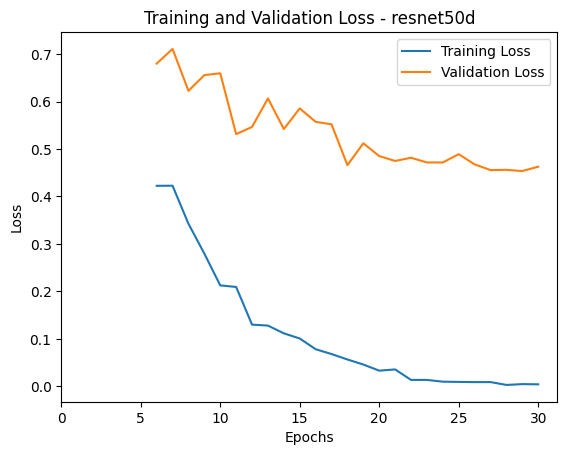

In [89]:
# Generate a sequence of integers to represent the epoch numbers

#lr = 1e-3 resnet50d
# {"epoch": 38, "train_loss": 0.005440620369356598, "valid_loss": 0.4425026864779216, "accuracy": 0.914605438709259, "learning_rate": 1.2481454142189669e-05, "model_architecture": "resnet50d"}
epochs=40
epochs_list = range(1, epochs+1)
train_loss_list=[4.565216123777936, 2.699557208119424, 1.1479259332021077, 0.5802670901230244, 0.41889409287154955, 0.40454295312574773, 0.38789343613554056, 0.39595943493462504, 0.35998398898073203, 0.3416068993263961, 0.2475385653825713, 0.2132154384129484, 0.19504644872157226, 0.1611216833613848, 0.15628602263898078, 0.12912011282964492, 0.1371539938897594, 0.09752902998960634, 0.0839079188558977, 0.07606565658475312, 0.061241830738497455, 0.0586928354112755, 0.06198096460719624, 0.05833861467913842, 0.05012982802142, 0.03351758780261773, 0.031194852743770034, 0.020167585256828668, 0.015919786003448875, 0.01464408216997981, 0.014265770263676947, 0.007521256287429184, 0.009122672952064466, 0.007538272824330789, 0.006134277178349515, 0.0054847026820963535, 0.005756020136319643, 0.005440620369356598, 0.004174311801095979, 0.004740801001483566]
valid_loss_list=[3.614961858148928, 1.6477024775964242, 0.8014360406884441, 0.6261253279668314, 0.7298952677735576, 0.6225048458134687, 0.792936854340412, 0.6761455662824489, 0.7337347865104675, 0.6426199429013111, 0.7945768270227644, 0.6910291631464605, 0.632397520735308, 0.6656614917985819, 0.6112788107108187, 0.5906774523081603, 0.695176793469323, 0.5260141747141326, 0.5992850072819877, 0.5455807712343004, 0.6124614743446862, 0.4900366065126878, 0.5910838282218686, 0.5631262338547794, 0.49750678537896387, 0.4970191001754116, 0.49679933329699216, 0.49477827893915, 0.46178636824091274, 0.4768790304660797, 0.46218881059300015, 0.4663641125791603, 0.47557060627473724, 0.4519590521576228, 0.45117539705501664, 0.4515654217727758, 0.44413101162623475, 0.4425026864779216, 0.4436816606256697, 0.44991759259115766]

# lr = 1e-4 resnet152d
# {"epoch": 40, "train_loss": 0.01788316021712733, "valid_loss": 0.44067384654449093, "accuracy": 0.9093050360679626, "learning_rate": 4.624620102063668e-05, "model_architecture": "resnet152d"}
epochs=60
epochs_list = range(1, epochs+1)
train_loss_list=[5.2949551976342715, 5.017223416359772, 4.455857684354827, 3.8905170512311336, 3.0943425988927133, 2.1978046435145706, 1.4215535098957903, 0.8627730297370696, 0.5216177595613148, 0.3386732903724545, 0.23095295686677028, 0.16890720765985234, 0.13855552713565983, 0.11197709325403675, 0.1040827759099958, 0.10508108567533918, 0.08948794577463132, 0.06226790304614904, 0.07591885307305296, 0.07222845947518595, 0.05596493258022926, 0.0664448904424486, 0.05381052739953211, 0.04528930339035294, 0.05091149851399968, 0.04627972676860335, 0.034770746588567054, 0.023415934591785842, 0.029926622487569637, 0.029841493500370374, 0.02286306233473227, 0.022906055175502534, 0.024509425012683366, 0.02115032274468404, 0.019456897473111398, 0.01564347226295113, 0.017082372802733815, 0.01126674561818161, 0.011861023370683753, 0.01788316021712733, 0.013229044810147353, 0.014205086696455736, 0.008326488144765717, 0.007743906640740627, 0.006876343957415209, 0.010431629198957498, 0.006122243126084757, 0.008213313331416516, 0.007370244790340813, 0.004950084539891129, 0.002269475952560353, 0.0032545755761609952, 0.001910264267118324, 0.0032902085025545576, 0.003063809303697986, 0.006241315722185681, 0.002081082958920461, 0.004895216667316329, 0.003234977033776297, 0.0024601867676061085]
valid_loss_list=[5.197794596354167, 4.784333405671297, 4.16616983766909, 3.487807110503868, 2.5462980756053217, 1.7384101306950603, 1.0979482222486425, 0.7567057024549555, 0.5915367310797727, 0.5647973760410592, 0.48524587794586466, 0.4929950976813281, 0.473537710805734, 0.46343844825470887, 0.5621760092951633, 0.519107376811681, 0.49709746959032836, 0.5336914189435817, 0.5007438687262712, 0.4649186857320644, 0.5236672317540204, 0.48647359413681207, 0.497414265655809, 0.4439750871862526, 0.4906104323626668, 0.4750059373952724, 0.45197308870653313, 0.4676587462977127, 0.46040184437124815, 0.4522757189417327, 0.5023966915905476, 0.46492544644408756, 0.46164891510098066, 0.5182165500742418, 0.521224762002627, 0.49162088500128853, 0.47383796271902545, 0.479345908112548, 0.4607846843837588, 0.44067384654449093, 0.45055377428178434, 0.4618272693068893, 0.44697730870986424, 0.4736638481694239, 0.47652482482846137, 0.4637790196057823, 0.4691389501784687, 0.4583308363540305, 0.46117353929137744, 0.4647114625269616, 0.4585442172570361, 0.46777603444125915, 0.47480068673138265, 0.47111030060935905, 0.46624877655671704, 0.46905375499692226, 0.46500844853343787, 0.4734055790360327, 0.4611245492404258, 0.46895601372751927]

# lr = 1e-3 resnet152d
# {"epoch": 29, "train_loss": 0.0046670065783926155, "valid_loss": 0.4535963204861791, "accuracy": 0.9157832860946655, "learning_rate": 5.5363471042384826e-06, "model_architecture": "resnet152d"}
epochs=30
epochs_list = range(1, epochs+1)
train_loss_list=[4.337887297213917, 1.978157811601397, 0.7579075439435216, 0.5235124755073601, 0.5241319910391395, 0.42248238874992855, 0.4226863004721946, 0.34252732764807103, 0.27960754547950245, 0.21267147008941767, 0.20942838299372388, 0.1299891338416948, 0.12800121043279697, 0.11165643795590166, 0.1008056536351851, 0.07819386706315855, 0.06805013664101771, 0.05657005681275901, 0.0459065555546765, 0.03301978628960014, 0.035648101065176685, 0.013538027409586548, 0.013512671527238519, 0.009860045455850905, 0.009295787844661937, 0.008911630938905226, 0.00898215218836293, 0.002988970178253774, 0.0046670065783926155, 0.004230101693404113]
valid_loss_list=[3.034608483314514, 1.0951125389999814, 0.7182501466185959, 0.6831715498809461, 0.7877178926158834, 0.6799943877591027, 0.7109059122977434, 0.6225950091525361, 0.6557573557451919, 0.6595477395587497, 0.5314038304819001, 0.546561767105703, 0.6066066537190367, 0.5421067204464365, 0.5856348122987483, 0.5572700092086086, 0.552015853907775, 0.4660860560834408, 0.512078708037734, 0.4851629636767838, 0.47486882905165356, 0.4815587816690957, 0.4717292192357558, 0.471679227012727, 0.48917099460959435, 0.4676608431532427, 0.45566340418601475, 0.4561323054410793, 0.4535963204861791, 0.4627855976836549]


# Plot and label the training and validation loss values
plt.plot(epochs_list[5:], train_loss_list[5:], label='Training Loss')
plt.plot(epochs_list[5:], valid_loss_list[5:], label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss - resnet50d')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(np.arange(0, epochs+1, 5))
 
# Display the plot
plt.legend(loc='best')
plt.show()

In [ ]:
# Model Testing

In [55]:
#load model
# Create a pretrained ResNet model with the number of output classes equal to the number of class names
# 'timm.create_model' function automatically downloads and initializes the pretrained weights
resnet152 = timm.create_model(resnet_model, pretrained=True, num_classes=len(class_names))

# Set the device and data type for the model
resnet152 = resnet152.to(device=device, dtype=dtype)

# Add attributes to store the device and model name for later reference
resnet152.device = device
resnet152.name = resnet_model
model = resnet152


checkpoint_dir = f"model/{resnet_model}/"
# The model checkpoint path
checkpoint_path = checkpoint_dir + "handbag_classfication_weights.pth"
model.load_state_dict(torch.load(checkpoint_path))
model.eval()

# or

# model = torch.load(model_path, map_location=torch.device('cpu'))

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Co

In [56]:
class CustomImageTestDataset(Dataset):
    def __init__(self, image_files, transform=None, target_transform=None):
        self.img_labels = image_files
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, index):
        img_path =  self.img_labels[index]
        image = np.array(Image.open(img_path).convert('RGB'))
  
        if self.transform:
            image = self.transform(image)
        # if self.target_transform:
        #     label = self.target_transform(label)
        return image, img_path

In [81]:
# Select a random item from the dataset
img_path = random.choice(image_files)

label = '|'.join(img_path.split('\\')[5:-1])
# sample_img = Image.open(img_path)
    
# Display the label
print(f"Image Label: {label}")

Image Label: Miu Miu|vitello|satchel


In [82]:
test_imgs = [img_path]

test_dataset = CustomImageTestDataset(test_imgs, transform=valid_tfms)

for n,(X, p) in enumerate(test_dataset):
    with torch.no_grad():
        pred = model(X.to('cuda').unsqueeze(0))

    # Scale the model predictions to add up to 1
    pred_scores = torch.softmax(pred, dim=1)

    # Get the highest confidence score
    confidence_score = pred_scores.max()

    # Get the class index with the highest confidence score and convert it to the class name
    pred_class = classification_map.loc[classification_map.label_int==int(torch.argmax(pred_scores))].index[0]
    print(f'image:{p}')
    print(f'predict:{pred_class}')  

image:C:\Users\Administrator\Downloads\bag_image\Miu Miu\vitello\satchel\truefacet-3983909.jpg
predict:Miu Miu|vitello|satchel
